# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys
import multiprocessing

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.visibility.operations import create_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, smooth_image
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import raster_iter
from arl.image.solvers import solve_image
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_image_composite, \
    create_low_test_beam
from arl.fourier_transforms.ftprocessor import *

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW configuration

In [2]:
low = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
config = 'core'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=5 * 2048

else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=512
    
oversampling = 32

frequency = numpy.linspace(0.99e8, 1.01e8, 3)
channel_bandwidth=numpy.array([1e6, 1e6, 1e6])
times = numpy.linspace(-3, +3, 15) * numpy.pi / 12.0
log.info('Observing times %s' % (times))

log.info("Observing frequencies %s Hz" % (frequency))

log.info("Cellsize = %.6f radians" % (cellsize))

Observing times [-0.78539816 -0.67319843 -0.56099869 -0.44879895 -0.33659921 -0.22439948
 -0.11219974  0.          0.11219974  0.22439948  0.33659921  0.44879895
  0.56099869  0.67319843  0.78539816]
Observing frequencies [  9.90000000e+07   1.00000000e+08   1.01000000e+08] Hz
Cellsize = 0.001000 radians


In [4]:
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 616275 rows, 0.060 GB


Plot the synthesized uv coverage, including for MFS

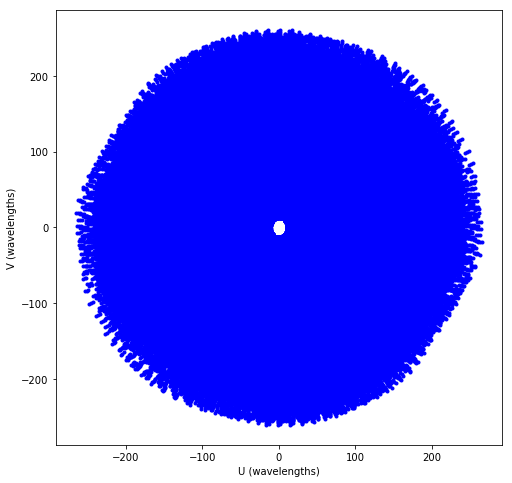

In [5]:
plt.clf()
plt.plot(vt.uvw[:,0],   vt.uvw[:,1], '.', color='b')
plt.plot(-vt.uvw[:,0], -vt.uvw[:,1], '.', color='b')
plt.xlabel("U (wavelengths)")
plt.ylabel("V (wavelengths)")
plt.show()

Make a test image

In [6]:
model = create_low_test_image_composite(npixel=npixel, frequency=frequency, channel_bandwidth=channel_bandwidth,
                                         cellsize=cellsize, 
                                         phasecentre=phasecentre)
export_image_to_fits(model, '%s/imaging-low-model.fits' % (results_dir))

create_low_test_image_from_gleam: 16178 sources inside the image
create_low_test_image_from_gleam: Flux in image = 16693.386
create_low_test_image: 118523 sources inside the image
create_low_test_image: flux in S3 model = 17379.614, actual flux in image = 17379.614


import_image_from_fits: created image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
create_low_test_beam: scaling to model frequency 99.000 MHz


Model * beam has 229.361 Jy


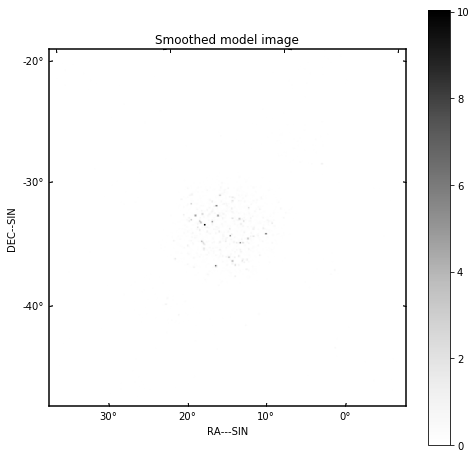

In [7]:
beam=create_low_test_beam(model)
model.data*=beam.data
print("Model * beam has %.3f Jy" % (numpy.sum(model.data[0,0,:,:])))
cmodel = smooth_image(model)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()
export_image_to_fits(cmodel, '%s/imaging-low-cmodel.fits' % (results_dir))
beam = None
cmodel = None

predict_2d: predict using 2d transform


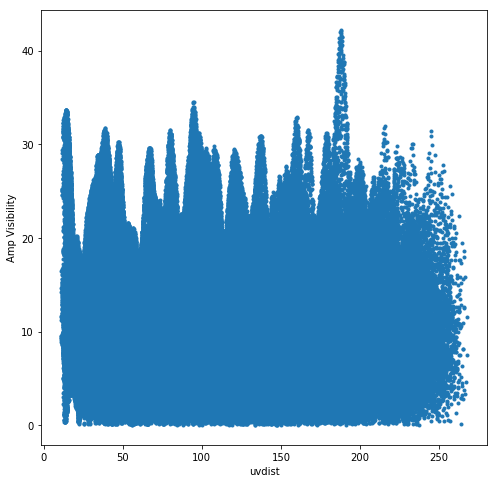

In [8]:
vt.data['vis'] *= 0.0
vt = predict_2d(vt, model, padding=1.0)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

From now on, we will work with MFS images

In [9]:
model = create_image_from_visibility(vt, npixel=npixel, nchan=1, phasecentre=phasecentre, cellsize=cellsize)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -35.)>, starting frequency 99000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 265.261057 wavelengths
create_image_from_visibility: Critical cellsize = 0.001885 radians, 0.107999 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees


Weight the data

weight_gridding: Performing uniform weighting


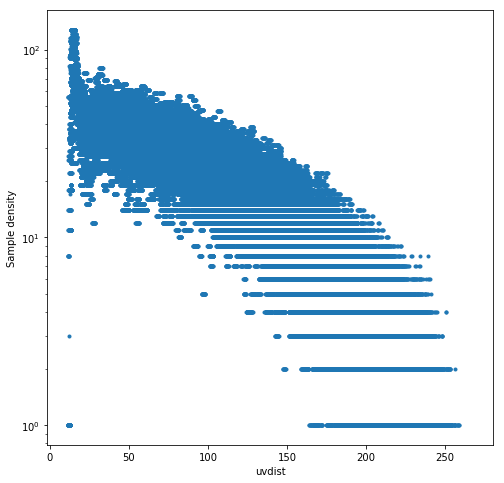

In [10]:
vt, density, densitygrid = weight_visibility(vt, model)
plt.clf()
plt.semilogy(uvdist, density, '.')
plt.xlabel('uvdist')
plt.ylabel('Sample density')
plt.show()
density = None
densitygrid = None

Make the dirty image and point spread function

invert_2d: inverting using 2d transform
invert_2d: inverting using 2d transform
Max, min in dirty image = 4.469916, -1.063939, sumwt = [[ 1.06335328]]
Max, min in PSF         = 1.000000, -0.176623, sumwt = [[ 1.06335328]]


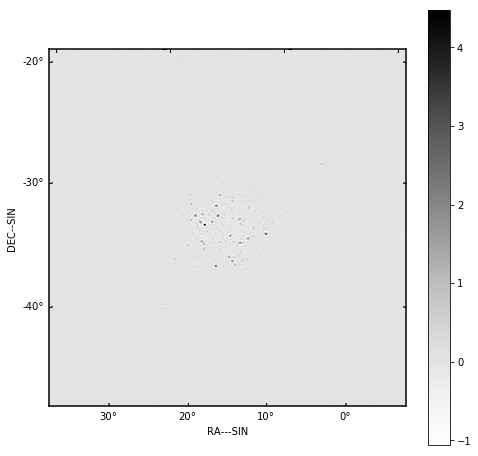

In [11]:
dirty, sumwt = invert_2d(vt, model, padding=1)
dirty = normalize_sumwt(dirty, sumwt)
show_image(dirty)

psf, sumwt = invert_2d(vt, model, dopsf=True, padding=1)
psf = normalize_sumwt(psf, sumwt)


print("Max, min in dirty image = %.6f, %.6f, sumwt = %s" % (dirty.data.max(), dirty.data.min(), sumwt))
print("Max, min in PSF         = %.6f, %.6f, sumwt = %s" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-low-dirty.fits' % (results_dir))
export_image_to_fits(psf, '%s/imaging-lof-psf.fits' % (results_dir))

dirty = None

Do some major cycles

solve_image: Performing 5 major cycles
predict_2d: predict using 2d transform
invert_2d: inverting using 2d transform
invert_2d: inverting using 2d transform
solve_image: Start of major cycle 0
deconvolve_cube: Processing pol 0, channel 0
hogbom: Minor cycle 0, peak 4.02292407628 at [259, 222]
hogbom: Minor cycle 100, peak 1.13348483626 at [263, 233]
hogbom: Minor cycle 200, peak 0.755893075125 at [260, 274]
hogbom: Minor cycle 300, peak 0.577905563472 at [272, 241]
hogbom: Minor cycle 400, peak 0.45840004391 at [293, 262]
hogbom: Minor cycle 500, peak 0.384287148463 at [200, 238]
hogbom: Minor cycle 600, peak 0.335235060087 at [239, 284]
hogbom: Minor cycle 700, peak 0.29741513031 at [207, 262]
hogbom: Minor cycle 800, peak 0.267765365526 at [217, 260]
hogbom: Minor cycle 900, peak 0.245066282455 at [212, 265]
predict_2d: predict using 2d transform
invert_2d: inverting using 2d transform
solve_image: End of major cycle
solve_image: Start of major cycle 1
deconvolve_cube: Processing po

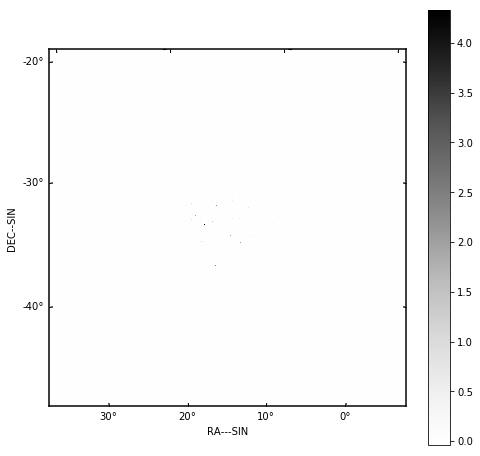

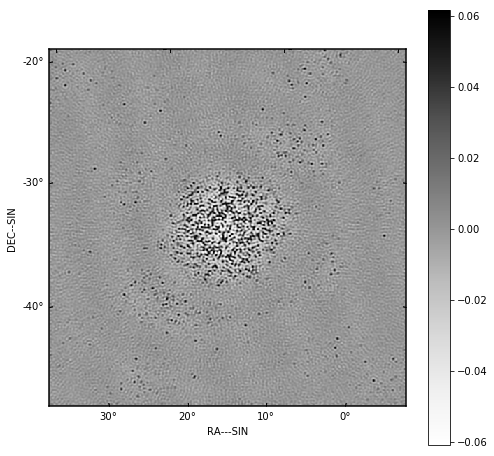

In [12]:
model.data[...] = 0.0
vtres, comp, residual = solve_image(vt, model, niter=1000, fractional_threshold=0.1, threshold=0.050, nmajor=5,
                                   gain=0.1, algorithm='hogbom', padding=1)

fig=show_image(comp)
fig=show_image(residual)

The fit may be unsuccessful; check fit_info['message'] for more information.
Model: GaussianConst2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        constant      amplitude        x_mean    ...    y_stddev        theta    
    --------------- -------------- ------------- ... -------------- -------------
    0.0115103998629 0.901041496585 7.01707037465 ... -0.24427202324 17.2169016818
restore_cube: error in fitting to psf, using 1 pixel stddev


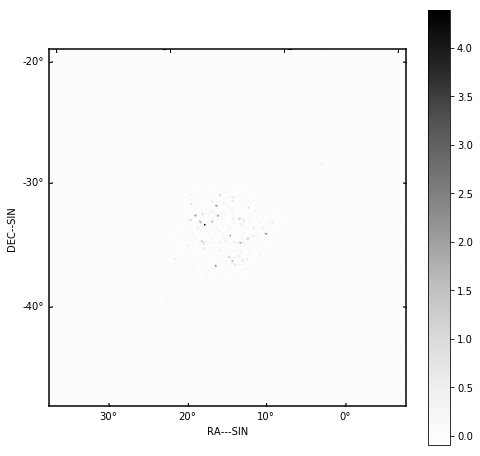

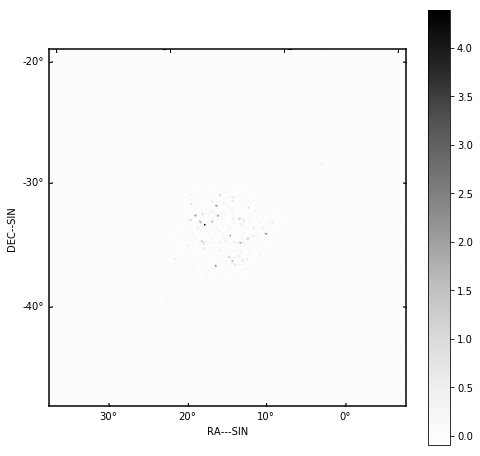

In [13]:
clean = restore_cube(model=comp, psf=psf, residual=residual)
export_image_to_fits(clean, '%s/imaging-low-clean.fits' % (results_dir))
show_image(clean)

Predict the visibility of the model

In [14]:
vtmodel = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_2d(vtmodel, comp, timeslice=1.0)

create_visibility: 616275 rows, 0.060 GB
predict_2d: predict using 2d transform


Now we will plot the original visibility and the residual visibility.

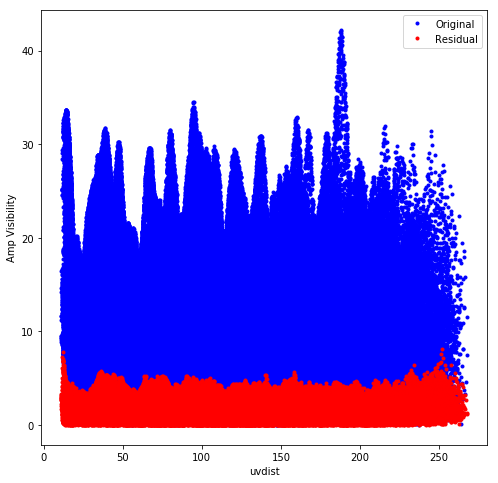

In [15]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.', color='b', label='Original')
plt.plot(uvdist, numpy.abs(vt.data['vis']-vtmodel.data['vis']), '.', color='r', label='Residual')


plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()